In [2]:
import os
import pickle

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
def shuffle_np(x, y):
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    x = x[indices]
    y = y[indices]
    return x, y


def shuffle_and_undersample(x, y):
    x, y = shuffle_np(x, y)

    min_len = np.minimum(np.sum(y == 1), np.sum(y == 0))

    x_zeros = x[(y == 0).reshape(-1)][:min_len]
    x_ones = x[(y == 1).reshape(-1)][:min_len]

    x = np.concatenate([x_zeros, x_ones])
    y = np.concatenate([np.zeros(min_len), np.ones(min_len)])
    x, y = shuffle_np(x, y)

    return x, y

In [4]:
def load_pickle_file(data_path, file_name: str = "dump.pickle"):
    with open(os.path.join(data_path, file_name), 'rb') as file:
        df = pickle.load(file)
    return df

In [5]:
def convert_to_cycle_np_array(df: pd.DataFrame, max_size: int = 200, with_welding_run: bool = False) -> tuple[np.ndarray, np.ndarray]:
    if with_welding_run:
        quality = df[["quality", "t_wn", "welding_run"]]
    else:
        quality = df[["quality", "t_wn"]]
    quality = quality.iloc[1:]
    quality = quality.iloc[::4]
    quality = quality.groupby("t_wn").first().values

    new_cycles_v = df["V"].rolling(4, step=4).mean().reset_index(drop=True).dropna()
    new_cycles_i = df["I"].rolling(4, step=4).mean().reset_index(drop=True).dropna()

    t_wn = df.t_wn.values[::4]
    t_wn = t_wn[1:]
    df = pd.DataFrame(data=np.array([t_wn, new_cycles_v.values, new_cycles_i.values]).T, columns=["t_wn", "V", "I"])
    df["t_wi"] = df.groupby("t_wn").cumcount()
    v_cycles = df.pivot(index="t_wn", columns='t_wi', values="V")
    i_cycles = df.pivot(index="t_wn", columns="t_wi", values="I")

    v_cycles = v_cycles.fillna(method="ffill", axis=1).values
    i_cycles = i_cycles.fillna(method="ffill", axis=1).values

    v_cycles = v_cycles[:, :max_size].reshape(-1, 1, max_size)
    i_cycles = i_cycles[:, :max_size].reshape(-1, 1, max_size)

    vi = np.concatenate([v_cycles, i_cycles], axis=1)
    return vi.swapaxes(1, 2), quality

In [6]:
def transform_df_to_ds(df: pd.DataFrame, max_size: int = 200, ds_type: str = "train", scaler=None) -> tuple[np.array, np.array]:
    x, y = convert_to_cycle_np_array(df, max_size=max_size)
    if ds_type == "train":
        x, y = shuffle_and_undersample(x, y)
    else:
        y = y.reshape(-1)
        x, y = shuffle_np(x, y)
    if scaler is not None:
        if ds_type == "train":
            scaler.fit(x)
        x = scaler.transform(x)
    return x, y


In [7]:
class MyScaler:

    def __init__(self) -> None:
        self.scaler = StandardScaler()

    def fit(self, x):
        s_0, s_1, s_2 = x.shape
        self.scaler.fit(x.reshape(-1, s_2))

    def transform(self, x):
        s_0, s_1, s_2 = x.shape
        x = self.scaler.transform(x.reshape(-1, s_2))
        return x.reshape(s_0, s_1, s_2)

    def inverse_transform(self, x):
        s_0, s_1, s_2 = x.shape
        x = self.scaler.inverse_transform(x.reshape(-1, s_2))
        return x.reshape(s_0, s_1, s_2)

In [8]:
def create_dataset_cycle(data_path="./data/"):
    """Create the dataset based on the cycle interval."""
    test_welding_run_good = 3
    test_welding_run_bad = 20
    
    scaler = MyScaler()
    df = load_pickle_file(data_path=data_path, file_name="welding_data_label.pickle")
    
    train_df = df[
        (df.experiment == 1) & (df.welding_run != test_welding_run_good) & (df.welding_run != test_welding_run_bad)]
    test_df = df[
        (df.experiment == 1) & ((df.welding_run == test_welding_run_good) | (df.welding_run == test_welding_run_bad))]
    
    
    x, y = transform_df_to_ds(train_df, ds_type="train", scaler=scaler)
    train_x, train_y = x[:int(len(x)*0.85)], y[:int(len(x)*0.85)]
    val_x, val_y = x[int(len(x)*0.85):], y[int(len(x)*0.85):]
    test_x, test_y = transform_df_to_ds(test_df, ds_type="val", scaler=scaler)

    return train_x, train_y, val_x, val_y, test_x, test_y, scaler



train_x, train_y, val_x, val_y, test_x, test_y, scaler = create_dataset_cycle(data_path="./")

In [9]:
train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape

((16371, 200, 2), (16371,), (2889, 200, 2), (2889,), (2620, 200, 2), (2620,))

One input sample shape (200, 2)


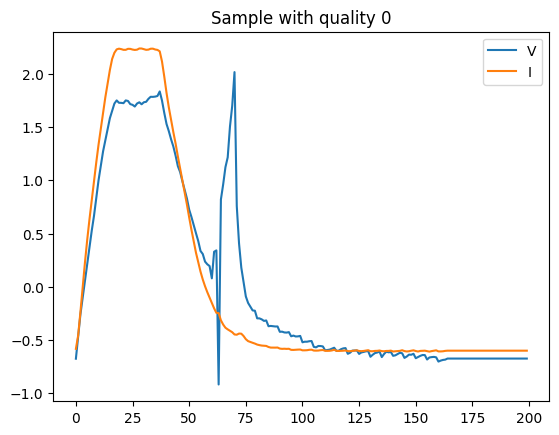

In [10]:
# one input sample
print(f"One input sample shape {train_x[0].shape}")
plt.plot(train_x[0, :, 0], label="V")
plt.plot(train_x[0, :, 1], label="I")
plt.title(f"Sample with quality {int(train_y[0])}")
plt.legend()
plt.show()

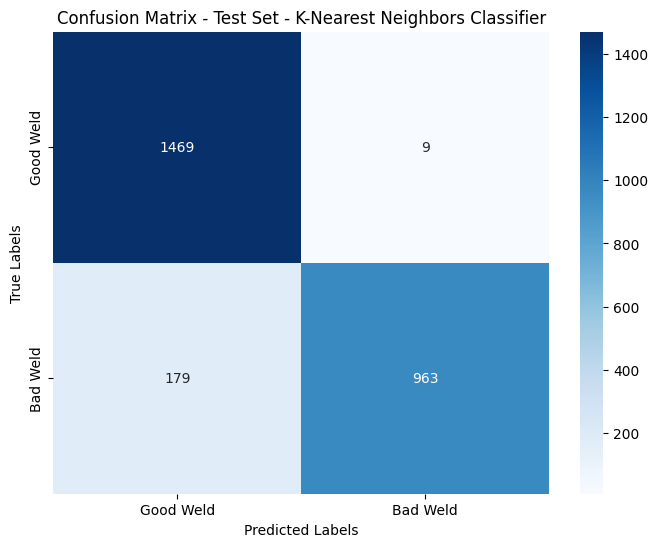


Validation Accuracy: 0.6642436829352717
Test Accuracy: 0.9282442748091603
Classification Report - Test Set:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1478
           1       0.99      0.84      0.91      1142

    accuracy                           0.93      2620
   macro avg       0.94      0.92      0.93      2620
weighted avg       0.93      0.93      0.93      2620

Confusion Matrix - Test Set:
[[1469    9]
 [ 179  963]]
Cross-validation scores: [0.66351145 0.65546732 0.6744044  0.66921197 0.68814905]
Average cross-validation score: 0.670148838640783


In [11]:
# k-NN classification

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

train_x_knn = train_x.reshape(train_x.shape[0], -1)
val_x_knn = val_x.reshape(val_x.shape[0], -1)
test_x_knn = test_x.reshape(test_x.shape[0], -1)

knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(train_x_knn, train_y)

val_predictions_knn = knn_classifier.predict(val_x_knn)
test_predictions_knn = knn_classifier.predict(test_x_knn)

# Calculate the accuracy of the predictions on the validation data
val_accuracy_knn = accuracy_score(val_y, val_predictions_knn)

# Calculate the accuracy of the predictions on the test data
test_accuracy_knn = accuracy_score(test_y, test_predictions_knn)

# Create confusion matrix for test data
test_cm_knn = confusion_matrix(test_y, test_predictions_knn)

# Plot the confusion matrix for the test data
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm_knn, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix - Test Set - K-Nearest Neighbors Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0.5, 1.5], ['Good Weld', 'Bad Weld'])
plt.yticks([0.5, 1.5], ['Good Weld', 'Bad Weld'])
plt.show()
print()

# Create classification report for test data
test_classification_report_knn = classification_report(test_y, test_predictions_knn)

# Perform cross-validation
cv_scores_knn = cross_val_score(knn_classifier, train_x_knn, train_y, cv=5)
average_cv_score_knn = cv_scores_knn.mean()

print('Validation Accuracy:', val_accuracy_knn)
print('Test Accuracy:', test_accuracy_knn)
print('Classification Report - Test Set:')
print(test_classification_report_knn)
print('Confusion Matrix - Test Set:')
print(test_cm_knn)
print("Cross-validation scores:", cv_scores_knn)
print("Average cross-validation score:", average_cv_score_knn)


In [13]:
# Hyperparameter tuning for K-Nearest Neighbors Algorithm

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Initialize your KNeighborsClassifier
knn_classifier = KNeighborsClassifier()

# Define the hyperparameters grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto'],
}

grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, verbose=2, n_jobs=-1)

grid_search.fit(train_x_knn, train_y)

best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

val_predictions = grid_search.best_estimator_.predict(val_x_knn)
test_predictions = grid_search.best_estimator_.predict(test_x_knn)

val_accuracy = accuracy_score(val_y, val_predictions)
test_accuracy = accuracy_score(test_y, test_predictions)

print(f"Validation accuracy with best estimator: {val_accuracy}")
print(f"Test accuracy with best estimator: {test_accuracy}")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Validation accuracy with best estimator: 0.74177916233991
Test accuracy with best estimator: 0.9618320610687023
